# NMF Analysis

Use NMF to take dataset of documents and sort into buckets.

Use K Means to group similar buckets into clusters.

Plot the fraction of documents in a cluster over time

In [1]:
import pickle
import datetime
from dateutil.parser import parse

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np


import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import matplotlib.pyplot as plt

#nltk.download()

In [4]:
# read data from pickle file
with open ('data/all_data_desk_nohole.pkl', 'rb') as fp:
    df = pickle.load(fp)
    
df.shape

(274606, 4)

In [5]:
# there's some bad data in the snippets.  Drop the rows that have NaN to clean this up
df.dropna(inplace=True)

# choose which news desks to include
news_desk_use = ['Business',
                 'Foreign',
                 'NewsDesk',
                 'National',
                 'Politics',
                 'U.S.',
                 'U.S. / Politics',
                 'U.S. / Election 2016',
                 'Washington',
                 'World / Europe',
                 'World / Middle East',
                 'World / Asia Pacific',
                 'World / Africa',
                 'World / Americas']
df2 = pd.DataFrame()
for desk in news_desk_use:
    topic = df['news_desk'] == desk
    df2 = pd.concat([df2,df[topic]])

df2['head_snip'] = df2['headline'] + ' '+ df2['snippet']

dates = list(df2['date'].copy())

documents = list(df2['head_snip'].copy())

df2.shape

# write data to pickle file
#with open('data/df2.pkl', 'wb') as fp:
#    pickle.dump(df2, fp)
    

(84582, 5)

## NMF

In [6]:
no_features = 2000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2, 
                                   max_features=no_features, 
                                   stop_words='english')
#tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [7]:
no_topics = 50

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

## K Means

In [8]:
# plot the trends in K Means clusters over time
# can choose month or week

def plot_topic_trend_ldaKM(groups, predict, dates):
    # groups = number of groups (int)
    # predict = array of group number
    # dates = array of dates that matches predict
    plt.figure(figsize=(17,8))
    min_date = min(dates)
    max_date = max(dates)
    min_year, min_week, weekday = min_date.isocalendar()
    max_year, max_week, weekday = max_date.isocalendar()

    plot_data_all = pd.DataFrame(columns=['topic','date','num_docs'])
    
    #timeframe = 'week'
    timeframe = 'month'
    if timeframe == 'week':
        week_start = min_week
        week_end = (max_year-min_year)*52+max_week + 1

        w = week_end - week_start
        
        for topic in range(groups):
            for week in range(week_start,week_end): 
                plot_data_all.at[w*topic+week,'topic'] = topic
                plot_data_all.at[w*topic+week,'date'] = week
        print('weeks in dataframe', week_start, week_end, w)

    
    elif timeframe == 'month':
        month_start = min_date.month
        max_month = max_date.month
        month_end = (max_year-min_year)*12+max_month + 1
        
        m = month_end - month_start
        
        for topic in range(groups):
            for month in range(month_start,month_end): 
                plot_data_all.at[m*topic+month,'topic'] = topic
                plot_data_all.at[m*topic+month,'date'] = month
        print('months in dataframe', month_start, month_end, m)
    
    plot_data_all['num_docs'] = 0
    plot_data_all = plot_data_all.astype('int')    
    print('set up dataframe for data',plot_data_all.info())
    
    for doc_idx in range(predict.shape[0]):
        try:
            topic_idx = predict[doc_idx]

            date_key = dates[doc_idx]
            if timeframe == 'week':
                year, week, weekday = date_key.isocalendar()

                if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                    week += 52
                elif year == 2017:
                    week += 104
                elif year == 2018:
                    week += 156
                #print(w*topic_idx+week)
                plot_data_all.loc[w*topic_idx + week,'num_docs'] +=  1
                
            elif timeframe == 'month':
                year = date_key.year
                month = date_key.month
                if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                    month += 12
                elif year == 2017:
                    month += 24
                elif year == 2018:
                    month += 36

                plot_data_all.loc[m*topic_idx + month,'num_docs'] +=  1

        except:
            topic_idx = predict[doc_idx]
            date_key = dates[doc_idx]
            year, week, weekday = date_key.isocalendar()
            month = date_key.month
        
    # Normalize the values (percent per time period)
    month_doc_totals = plot_data_all.groupby('date').sum()['num_docs']
    
    for i in range(len(plot_data_all)):
        d = plot_data_all.iloc[i,1]
        if month_doc_totals[d] != 0:
            plot_data_all.iloc[i,2] /= month_doc_totals[d]

    for topic in range(groups):
        foo = plot_data_all[plot_data_all['topic'] == topic]
        plt.figure()
        plt.plot(foo['date'],foo['num_docs'],label=f'Topic {topic}')
        plt.legend(loc='upper left');
        
#    return
    return plot_data_all

trying 1 clusters
trying 2 clusters
trying 3 clusters
trying 4 clusters
trying 5 clusters
trying 6 clusters
trying 7 clusters
trying 8 clusters
trying 9 clusters
trying 10 clusters
trying 11 clusters
trying 12 clusters
trying 13 clusters
trying 14 clusters
trying 15 clusters
trying 16 clusters
trying 17 clusters
trying 18 clusters
trying 19 clusters
trying 20 clusters
trying 21 clusters
trying 22 clusters
trying 23 clusters
trying 24 clusters
trying 25 clusters
trying 26 clusters
trying 27 clusters
trying 28 clusters
trying 29 clusters
trying 30 clusters
trying 31 clusters
trying 32 clusters
trying 33 clusters
trying 34 clusters
trying 35 clusters
trying 36 clusters
trying 37 clusters
trying 38 clusters
trying 39 clusters
trying 40 clusters
trying 41 clusters
trying 42 clusters
trying 43 clusters
trying 44 clusters
trying 45 clusters
trying 46 clusters
trying 47 clusters
trying 48 clusters
trying 49 clusters
trying 50 clusters


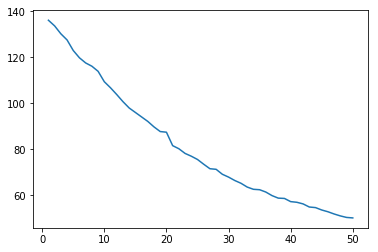

In [9]:
output = {}
for c in range(1,51):
    print(f'trying {c} clusters')
    km = KMeans(n_clusters=c,random_state=10,n_init=1)
    km.fit(nmf_W)
    output[c] = km.inertia_

plt.plot(output.keys(),output.values())

In [10]:
c = 20
km = KMeans(n_clusters=c,random_state=10,n_init=1)
km.fit(nmf_W)
predict = km.predict(nmf_W)

months in dataframe 1 48 47
<class 'pandas.core.frame.DataFrame'>
Int64Index: 940 entries, 1 to 940
Data columns (total 3 columns):
topic       940 non-null int64
date        940 non-null int64
num_docs    940 non-null int64
dtypes: int64(3)
memory usage: 69.4 KB
set up dataframe for data None


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1224x576 with 0 Axes>

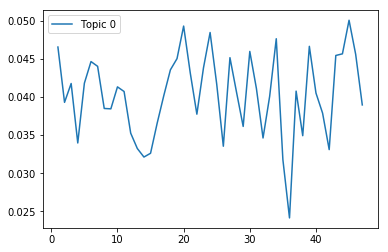

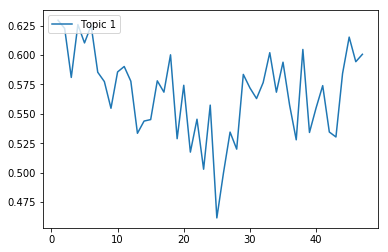

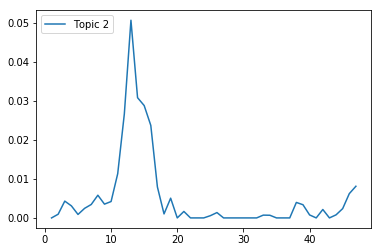

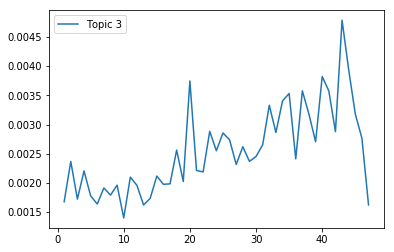

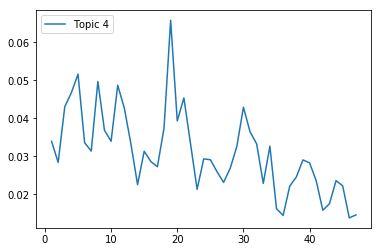

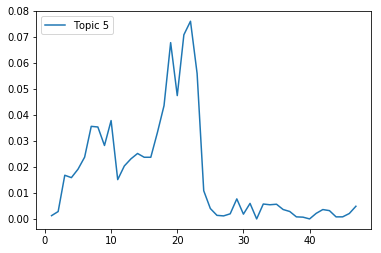

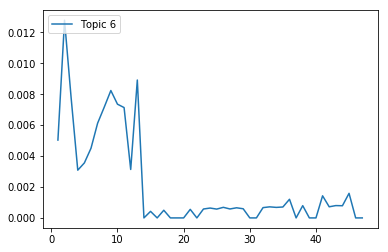

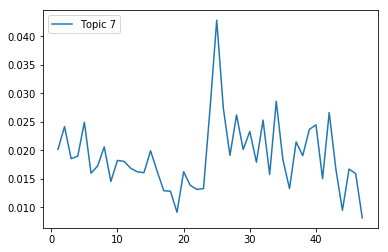

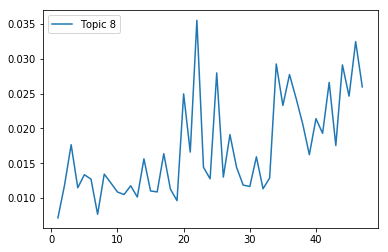

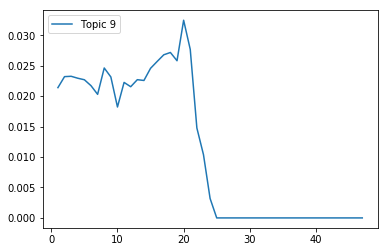

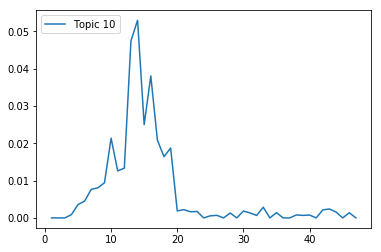

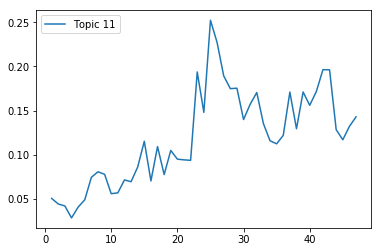

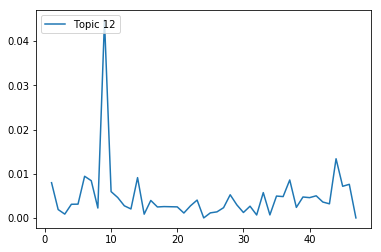

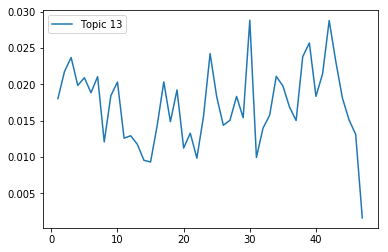

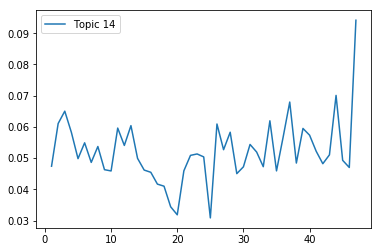

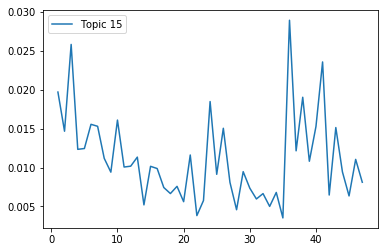

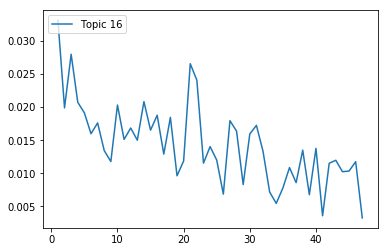

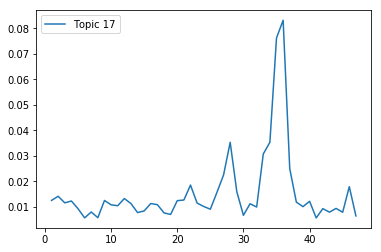

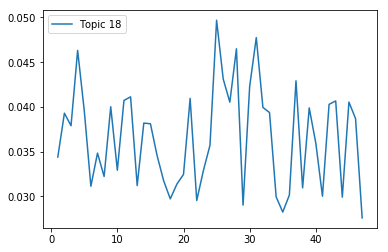

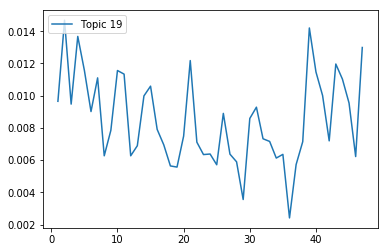

In [11]:
plot_data_all = plot_topic_trend_ldaKM(c, predict, dates)
plot_data_all.to_csv('data/plot_data_all_nmf.csv')

In [12]:
# print articles closest to centroid from K-Means

from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter

centers = np.array(km.cluster_centers_)

mat = nmf_W

for i in range(c):
    print(f'K Means Cluster {i}')
    cent = centers[i].reshape(50,-1)
    cent = cent.T
    #print(cent)
    
    dist = euclidean_distances(cent, mat)
    min_dist = min(dist[0][1:])
    #print('min euclidean distance = ',min_dist)
    
    dist_list = []
    for pt in range(len(predict)):
        if predict[pt] == i:
            if dist[0][pt] < 1.3* min_dist:
                dist_list.append([dist[0][pt],str(dates[pt].month)+'/'+str(dates[pt].year), documents[pt]])
                #print(str(dates[pt].month)+'/'+str(dates[pt].year), documents[pt])
    sort_dist_list = sorted(dist_list, key=lambda x: x[0])
    for i in range(8):
        try:
            print(sort_dist_list[i][0], sort_dist_list[i][1],sort_dist_list[i][2])
        except:
            print('no more in list')
    
    print(" ")


K Means Cluster 0
0.0059875546826889 5/2015 India: Border Dispute With Bangladesh Nears an End A constitutional amendment paves the way for a resolution by exchanging pockets of land near the border and allowing thousands of people to choose their citizenship....
0.006314498594643662 8/2017 U.S. Army Crew and Pilots Missing After Helicopter Disappears in Hawaii The Coast Guard was searching for five people who were aboard a Black Hawk helicopter in a training exercise. It was the third crash in about a month involving U.S. military aircraft.
0.006317085447010237 4/2016 Suicide Attempts Plague Attawapiskat First Nation in Canada Since September, 101 people in a remote aboriginal community have attempted suicide. That’s about 5 percent of its population....
0.00650279697279014 9/2016 Mont Blanc Cable Car Passengers Are Stranded Aloft Overnight in French Alps Helicopters rescued dozens of people at 12,500 feet in the Mont Blanc massif near Chamonix after the cars came to a halt....
0.0065

0.01037545434515544 2/2016 Hillary Clinton Donors Hear Concerns About Nevada Outcome Hillary Clinton’s campaign manager briefed some of her most loyal and active fund-raisers this morning about the upcoming Nevada caucuses and responded to frustrations among some of her donors that the campaign needed to do a better job of demon...
0.010417072905140726 9/2016 Theories of the Race: How Solid Is Hillary Clinton’s Lead? The relatively large number of undecided voters is partly responsible for the volatility in polling and may point to the importance of the debates....
0.01049267104811496 10/2016 For Democrats, Anthony Weiner Makes an Unwelcome Return In the campaign’s waning days, the disgraced congressman is at the center of the F.B.I.’s renewed interest in Hillary Clinton’s private email server....
0.010538378270797611 7/2016 Assange, Avowed Foe of Clinton, Timed Email Release for Democratic Convention Julian Assange, WikiLeaks founder, suggested in a June interview that he opposed Mrs.

0.009466789107090633 6/2018 Paul Ryan Dismisses Trump ‘Spy’ Charge as G.O.P. Shows Signs of Resistance Speaker Paul D. Ryan backed Representative Trey Gowdy in dismissing President Trump’s assertion that the F.B.I. inserted a “spy” into his campaign.
0.01018387653215892 9/2018 Who Is a Senior Administration Official? It Depends An anonymous senior administration official wrote an Op-Ed sharply critical of President Trump. The potential authors may number in the hundreds.
0.010470292202871401 5/2017 Senate Panel Asks Comey to Testify on Flynn and Trump The Senate Intelligence Committee invited the former F.B.I. director James B. Comey to testify on reports that President Trump asked him to scuttle the investigation into Michael T. Flynn....
0.010512877382822715 11/2016 Where Donald Trump Stands on School Choice, Student Debt and Common Core The president-elect has sent mixed signals on education policy, but here is an overview of what schools and universities might expect from his admin

0.009913775590349646 12/2017 Republicans, Closing In on Final Tax Bill, Aim for a Vote Next Week In a frenzy of last-minute negotiations, Republicans drew closer to a 21 percent corporate tax rate and a top individual rate of 37 percent.
0.010498428061798864 11/2017 Ahead of Vote, Promised Treasury Analysis of Tax Bill Proves Elusive Steven Mnuchin, the Treasury secretary, has promised that an analysis of the tax bill will show robust economic growth, but that report has yet to materialize.
0.010671133620733408 4/2017 Movers: Tax Cuts, Twitter and a Pokémon Bounce We’re following major developments in the markets throughout the day....
0.010729618870097624 10/2017 Mnuchin Talks Taxes and That Vanishing Treasury Study Steven Mnuchin, the Treasury secretary, shared his thinking about the status of the tax overhaul, financial regulation and life in the spotlight.
0.010999469792625442 1/2018 Treasury Inspector General Finds No Political Meddling in Tax Analysis The Treasury Department’s fa